ResnetModel3HeadsSplitNormalizationTightCoupled(
  (firstconv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(

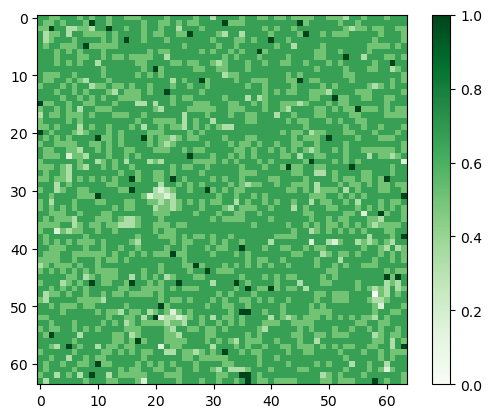

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import importlib
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

def normalize_normal(normals):
    normals_norm = torch.sqrt(torch.sum(torch.pow(normals, 2), 1)).unsqueeze(1).repeat(1, 3, 1, 1) + 1e-8
    return torch.div(normals, normals_norm)

def normalize_coords(coords):
    coord_n = coords[:, 0:3, :, :]
    coord_u = coords[:, 3:6, :, :]
    return torch.cat((normalize_normal(coord_n), normalize_normal(coord_u)), 1)

class conv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, stride):
        super(conv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_base = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=kernel_size, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        p = int(np.floor((self.kernel_size - 1) / 2))
        p2d = (p, p, p, p)
        x = self.conv_base(F.pad(x, p2d))
        x = self.normalize(x)
        return F.elu(x, inplace=True)

class upconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = conv(num_in_layers, num_out_layers, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

class ResnetModel3HeadsSplitNormalizationTightCoupled(nn.Module):
    def __init__(self, num_in_layers, encoder, pretrained):
        super(ResnetModel3HeadsSplitNormalizationTightCoupled, self).__init__()
        self.pretrained = pretrained
        assert encoder in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'], "Incorrect encoder type"
        if encoder in ['resnet18', 'resnet34']:
            filters = [64, 128, 256, 512]
        else:
            filters = [256, 512, 1024, 2048]
        resnet = class_for_name("torchvision.models", encoder)(pretrained=pretrained)
        if num_in_layers != 3:  # Number of input channels
            self.firstconv = nn.Conv2d(num_in_layers, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        else:
            self.firstconv = resnet.conv1  # H/2
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool  # H/4

        # encoder
        self.encoder1 = resnet.layer1  # H/4
        self.encoder2 = resnet.layer2  # H/8
        self.encoder3 = resnet.layer3  # H/16
        self.encoder4 = resnet.layer4  # H/32

        # decoder camera
        self.upconv6_cam = upconv(filters[3], 512, 3, 2)
        self.iconv6_cam = conv(filters[2] + 512, 512, 3, 1)
        self.upconv5_cam = upconv(512, 256, 3, 2)
        self.iconv5_cam = conv(filters[1] + 256, 256, 3, 1)
        self.upconv4_cam = upconv(256, 128, 3, 2)
        self.iconv4_cam = conv(filters[0] + 128, 128, 3, 1)
        self.upconv3_cam = upconv(128, 64, 3, 1)
        self.iconv3_cam = conv(64 + 64, 64, 3, 1)
        self.upconv2_cam = upconv(64, 32, 3, 1)
        self.iconv2_cam = conv(64 + 32, 32, 3, 1)
        self.upconv1_cam = upconv(32, 16, 3, 1)
        self.iconv1_cam = conv(16, 16, 3, 1)
        self.nu_layer_cam = get_normal(16, 9)

    def forward(self, x):
        # normalize to imagenet statistics
        x = self.normalize_input(x)

        # encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x_pool1 = self.firstmaxpool(x)

        x_pool2 = self.encoder1(x_pool1)
        x_pool3 = self.encoder2(x_pool2)
        x_pool4 = self.encoder3(x_pool3)
        x_pool5 = self.encoder4(x_pool4)

        # camera
        x_up6_cam = self.upconv6_cam(x_pool5)
        print("x_pool4 size:", x_pool4.size())
        print("x_up6_cam size:", x_up6_cam.size())
        x_up6_cam = torch.cat((x_pool4, x_up6_cam), 1)
        x_iconv6_cam = self.iconv6_cam(x_up6_cam)

        x_up5_cam = self.upconv5_cam(x_iconv6_cam)
        print("x_pool3 size:", x_pool3.size())
        print("x_up5_cam size:", x_up5_cam.size())
        x_up5_cam = torch.cat((x_pool3, x_up5_cam), 1)
        x_iconv5_cam = self.iconv5_cam(x_up5_cam)

        x_up4_cam = self.upconv4_cam(x_iconv5_cam)
        print("x_pool2 size:", x_pool2.size())
        print("x_up4_cam size:", x_up4_cam.size())
        x_up4_cam = torch.cat((x_pool2, x_up4_cam), 1)
        x_iconv4_cam = self.iconv4_cam(x_up4_cam)

        x_up3_cam = self.upconv3_cam(x_iconv4_cam)
        print("x_pool1 size:", x_pool1.size())
        print("x_up3_cam size:", x_up3_cam.size())
        x_up3_cam = torch.cat((x_pool1, x_up3_cam), 1)
        x_iconv3_cam = self.iconv3_cam(x_up3_cam)

        x_up2_cam = self.upconv2_cam(x_iconv3_cam)
        x_up2_cam = torch.cat((x_pool1, x_up2_cam), 1)
        x_iconv2_cam = self.iconv2_cam(x_up2_cam)

        x_up1_cam = self.upconv1_cam(x_iconv2_cam)
        x_iconv1_cam = self.iconv1_cam(x_up1_cam)
        nu_cam = self.nu_layer_cam(x_iconv1_cam)

        # return camera geometry image
        return normalize_coords(nu_cam)

    def normalize_input(self, x):
        # normalize to imagenet statistics
        mean = torch.tensor(imagenet_stats['mean']).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor(imagenet_stats['std']).view(1, 3, 1, 1).to(x.device)
        return (x - mean) / std

def get_normal(in_channels, out_channels):
    return nn.Sequential(
        conv(in_channels, in_channels, 3, 1),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=1, bias=True)
    )

def class_for_name(module_name, class_name):
    # load the module, will raise ImportError if module cannot be loaded
    m = importlib.import_module(module_name)
    # get the class, will raise AttributeError if class cannot be found
    c = getattr(m, class_name)
    return c

def create_model(num_in_layers, encoder='resnet50', pretrained=None):
    # modify the model here
    if encoder == 'resnet50':
        model = ResnetModel3HeadsSplitNormalizationTightCoupled(num_in_layers, encoder, pretrained)
    else:
        raise ValueError("This model has not been implemented yet.")
    return model

def main():
    # Example usage:
    num_in_layers = 3  # Number of input channels (e.g., 3 for RGB)
    encoder = 'resnet50'  # Encoder type
    pretrained = True  # Use pretrained weights
    model = create_model(num_in_layers, encoder, pretrained)
    print(model)

    # Here you would load your input image
    image_path = r"S:\PROJECT\dfdc\train\fake\aapnvogymq_89_0.png"  # Update the path to your image file
    image = Image.open(image_path)

    # Define transformations to apply to the image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to 256x256
        transforms.ToTensor(),           # Convert PIL image to PyTorch tensor
    ])

    # Apply transformations to the image
    input_image = transform(image).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        camera_normals = model(input_image)

    # Post-process the camera normals
    # Convert to image format (for visualization, etc.)
    # You should implement this based on your specific application

    # Example: Reshape and convert to numpy array
    print(camera_normals)
    # camera_normals_img = camera_normals.squeeze().cpu().numpy()
    # camera_normals_img_rgb = cv2.cvtColor(camera_normals_img, cv2.COLOR_GRAY2RGB)

#     camera_normals_np = camera_normals.cpu().numpy()  # Convert to NumPy array

# # Rescale the values to the range [0, 255] if necessary
#     camera_normals_rescaled = (camera_normals_np - camera_normals_np.min()) * (255 / (camera_normals_np.max() - camera_normals_np.min()))

# # Plot the camera normals as an image
#     plt.imshow(camera_normals_rescaled, cmap='gray')
#     plt.colorbar()
#     plt.show()
    # camera_normals_np = camera_normals.cpu().numpy()  # Convert to NumPy array
    normals_xyz = camera_normals[:, :3]
    normals_xyz = normals_xyz.squeeze(0).permute(1, 2, 0)  # Reshape to (H, W, C)
    normals_xyz_np = normals_xyz.cpu().numpy()

    # Calculate the magnitude of the vectors
    magnitude = np.sqrt(np.sum(normals_xyz_np ** 2, axis=2))

    # Normalize the magnitude to range [0, 1]
    magnitude_normalized = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())

    # Visualize the magnitude as a grayscale image
    plt.imshow(magnitude_normalized, cmap='Greens')
    plt.colorbar()
    plt.show()

    # Visualize each channel separately
    # num_channels = camera_normals_np.shape[1]
    # fig, axs = plt.subplots(1, num_channels, figsize=(15, 3))  # Adjust figsize as needed
    # for i in range(num_channels):
    #     axs[i].imshow(camera_normals_np[0, i], cmap='gray')
    #     axs[i].set_title(f'Channel {i+1}')
    # plt.show()
    # # Display the image with camera geometry
    # cv2.imshow('Camera Geometry Image',  camera_normals_img_rgb)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


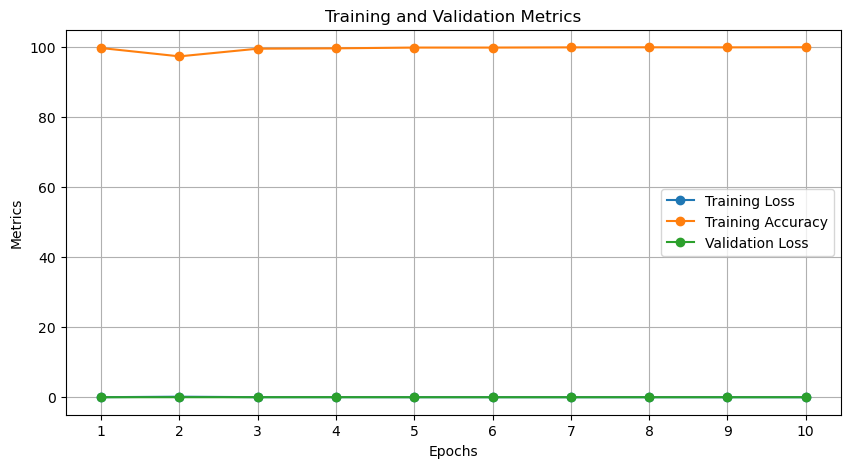

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define the training and validation metrics
epochs = np.arange(1, 11)
train_loss = [0.0087, 0.1497, 0.0141, 0.0154, 0.0081, 0.0060, 0.0031, 0.0021, 0.0025, 0.0014]
train_accuracy = [99.74, 97.36, 99.55, 99.65, 99.87, 99.87, 99.93, 99.95, 99.93, 99.97]
val_loss = [0.0, 0.0084, 0.0033, 0.0099, 0.0022, 0.0011, 0.0006, 0.0037, 0.0004, 0.0004]

# Plot the graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')

# Plot training accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-')

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


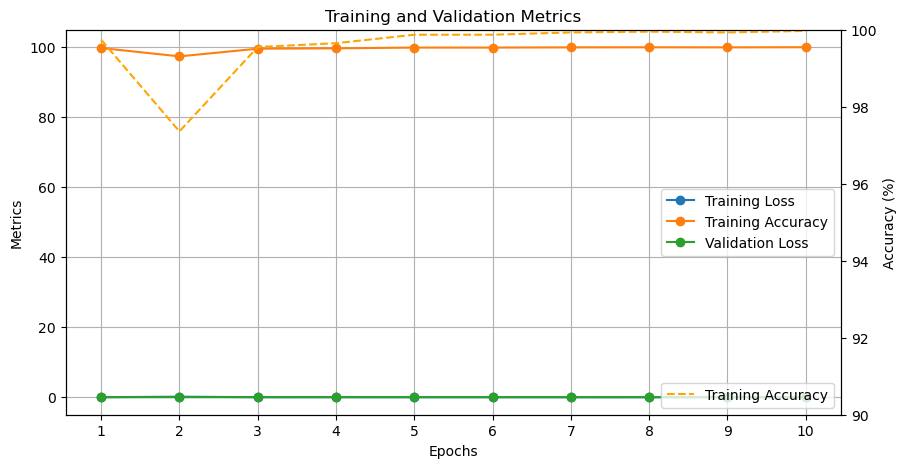

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the training and validation metrics
epochs = np.arange(1, 11)
train_loss = [0.0087, 0.1497, 0.0141, 0.0154, 0.0081, 0.0060, 0.0031, 0.0021, 0.0025, 0.0014]
train_accuracy = [99.74, 97.36, 99.55, 99.65, 99.87, 99.87, 99.93, 99.95, 99.93, 99.97]
val_loss = [0.0, 0.0084, 0.0033, 0.0099, 0.0022, 0.0011, 0.0006, 0.0037, 0.0004, 0.0004]

# Plot the graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')

# Plot training accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-')

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.twinx()
plt.ylabel('Accuracy (%)')  # Adding a secondary y-axis label for accuracy
plt.ylim(90, 100)  # Set the y-axis limit for accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='orange', linestyle='--')  # Re-plotting accuracy
plt.legend(loc='lower right')  # Move accuracy legend to avoid overlap
plt.show()


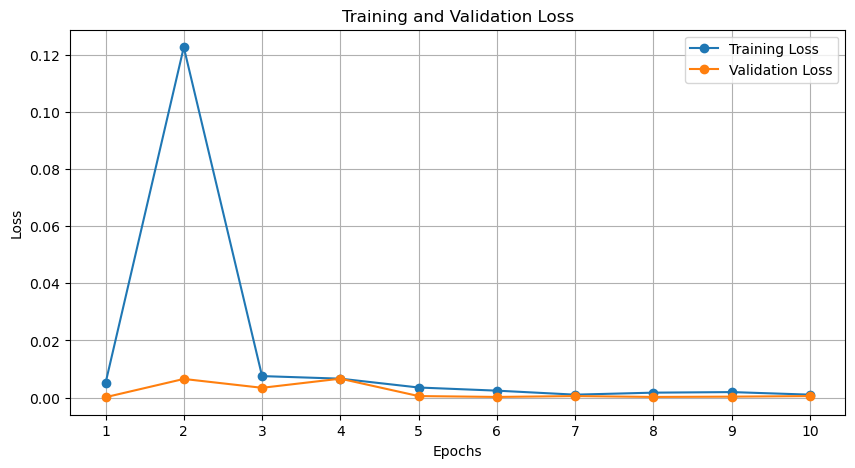

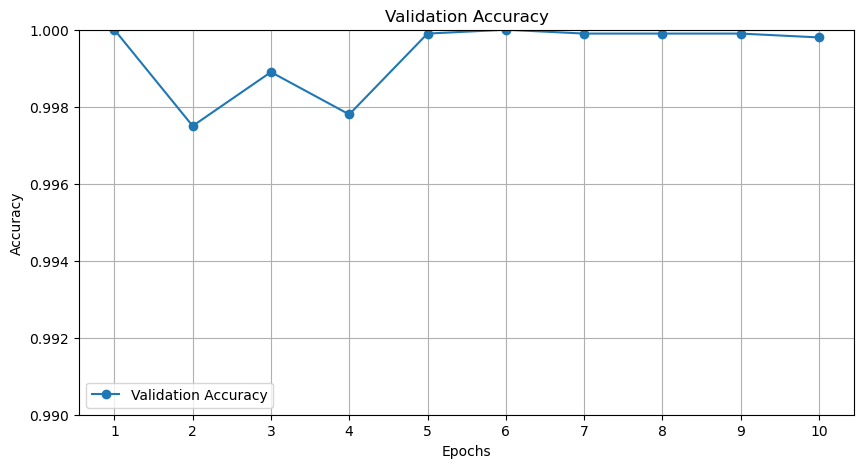

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the training and validation metrics
epochs = np.arange(1, 11)
train_loss = [0.0050, 0.1227, 0.0075, 0.0066, 0.0035, 0.0024, 0.0010, 0.0017, 0.0019, 0.0010]
val_loss = [0.0001, 0.0065, 0.0034, 0.0066, 0.0005, 0.0002, 0.0005, 0.0002, 0.0003, 0.0005]
val_accuracy = [1.0, 0.9975, 0.9989, 0.9978, 0.9999, 1.0, 0.9999, 0.9999, 0.9999, 0.9998]

# Plot the graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-')

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.ylim(0.99, 1.0)  # Set y-axis limit to better visualize accuracy changes
plt.legend()
plt.grid(True)
plt.show()


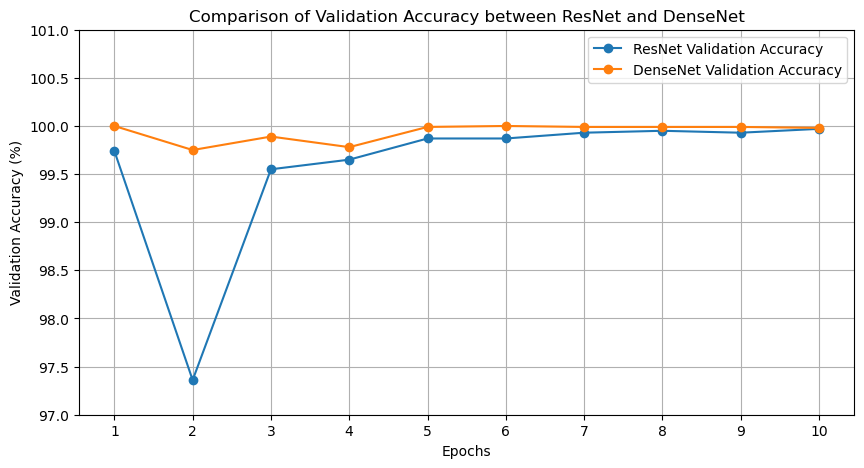

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define epochs and validation accuracy for ResNet and DenseNet
epochs = np.arange(1, 11)
resnet_val_accuracy = [99.74, 97.36, 99.55, 99.65, 99.87, 99.87, 99.93, 99.95, 99.93, 99.97]
densenet_val_accuracy = [100, 99.75, 99.89, 99.78, 99.99, 100, 99.99, 99.99, 99.99, 99.98]

# Plot the graph
plt.figure(figsize=(10, 5))

# Plot validation accuracy for ResNet
plt.plot(epochs, resnet_val_accuracy, label='ResNet Validation Accuracy', marker='o', linestyle='-')

# Plot validation accuracy for DenseNet
plt.plot(epochs, densenet_val_accuracy, label='DenseNet Validation Accuracy', marker='o', linestyle='-')

plt.title('Comparison of Validation Accuracy between ResNet and DenseNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.ylim(97, 101)  # Set y-axis limit to better visualize accuracy changes
plt.show()


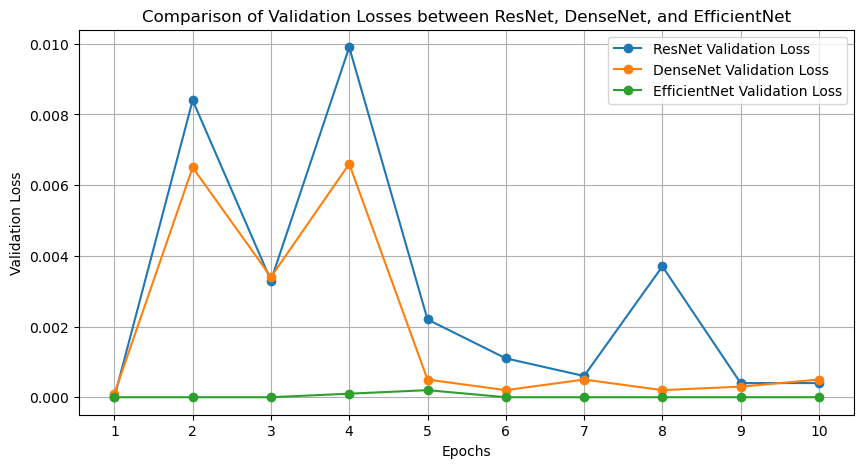

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define epochs and validation losses for ResNet, DenseNet, and EfficientNet
epochs = np.arange(1, 11)

resnet_val_loss = [0.0, 0.0084, 0.0033, 0.0099, 0.0022, 0.0011, 0.0006, 0.0037, 0.0004, 0.0004]
densenet_val_loss = [0.0001, 0.0065, 0.0034, 0.0066, 0.0005, 0.0002, 0.0005, 0.0002, 0.0003, 0.0005]
efficientnet_val_loss = [0.0, 0.0, 0.0, 0.0001, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0]

# Plot the graph
plt.figure(figsize=(10, 5))

# Plot validation loss for ResNet
plt.plot(epochs, resnet_val_loss, label='ResNet Validation Loss', marker='o', linestyle='-')

# Plot validation loss for DenseNet
plt.plot(epochs, densenet_val_loss, label='DenseNet Validation Loss', marker='o', linestyle='-')

# Plot validation loss for EfficientNet
plt.plot(epochs, efficientnet_val_loss, label='EfficientNet Validation Loss', marker='o', linestyle='-')

plt.title('Comparison of Validation Losses between ResNet, DenseNet, and EfficientNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()
